In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import openpyxl
from datetime import datetime

In [64]:
# we will be loading todays date as we will need to filter out between past and future plants 
current_year = datetime.now().year

print(f'the current year is: {current_year}')

the current year is: 2024


In [65]:
# loading into our env the eia form 860 generator excel
operable_data = pd.read_excel('input_data/3_1_Generator_Y2022.xlsx', 
                           sheet_name='Operable', skiprows=1)

# proposed generators sheet
proposed_data = pd.read_excel('input_data/3_1_Generator_Y2022.xlsx', 
                              sheet_name='Proposed', skiprows=1)

# retired and canceled worksheet
retired_data = pd.read_excel('input_data/3_1_Generator_Y2022.xlsx', 
                             sheet_name='Retired and Canceled', skiprows=1)


# print(operable_data.info())

print(proposed_data.info())

# print(retired_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 47 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Utility ID                                                               2024 non-null   object 
 1   Utility Name                                                             2023 non-null   object 
 2   Plant Code                                                               2023 non-null   float64
 3   Plant Name                                                               2023 non-null   object 
 4   State                                                                    2023 non-null   object 
 5   County                                                                   2018 non-null   object 
 6   Generator ID                                                            

In [66]:
# looking at only proposed plants, let's get plants with an effective year from 2024 and onwards
future_proposed = proposed_data[proposed_data['Effective Year'] >= current_year]

# also let's make the effective year an integer as opposed to a float
future_proposed['Effective Year'] = future_proposed['Effective Year'].astype(int)

# we will be removing 2033 because not enough projects so it looks empty
future_proposed = future_proposed[future_proposed['Effective Year'] != 2033]

print(future_proposed.info())

<class 'pandas.core.frame.DataFrame'>
Index: 595 entries, 9 to 2022
Data columns (total 47 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Utility ID                                                               595 non-null    object 
 1   Utility Name                                                             595 non-null    object 
 2   Plant Code                                                               595 non-null    float64
 3   Plant Name                                                               595 non-null    object 
 4   State                                                                    595 non-null    object 
 5   County                                                                   591 non-null    object 
 6   Generator ID                                                             594 n

C:\Users\AngelSalazar\AppData\Local\Temp\ipykernel_38112\2112185869.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_proposed['Effective Year'] = future_proposed['Effective Year'].astype(int)


In [67]:
# creating a function that will allow us to create facet type plots
def create_facet(data, col_val, facet_by, hue_by, colwrap=2, set_title='Please Insert Title'):

    graph = sns.FacetGrid(data, col=facet_by, col_wrap=colwrap, hue=hue_by, aspect=1.6)
    graph.map(sns.barplot, col_val, errorbar=None)

    # adding a legennd
    graph.add_legend()

    graph.fig.suptitle(set_title, y=1.05, fontsize=12)

    plt.show()

C:\Users\AngelSalazar\AppData\Roaming\Python\Python312\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


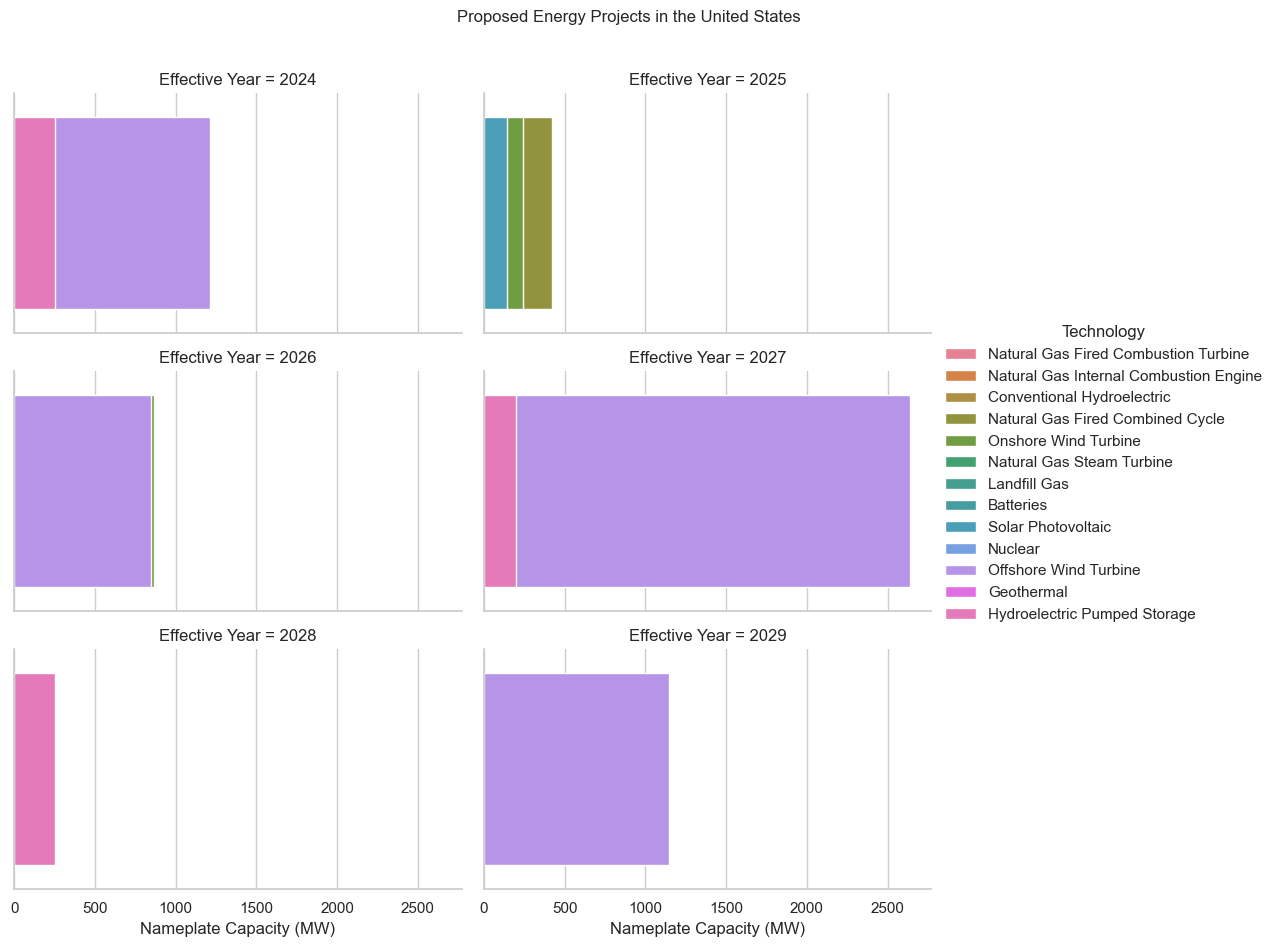

In [68]:
create_facet(data=future_proposed, col_val='Nameplate Capacity (MW)', facet_by='Effective Year', hue_by='Technology',
             set_title='Proposed Energy Projects in the United States')

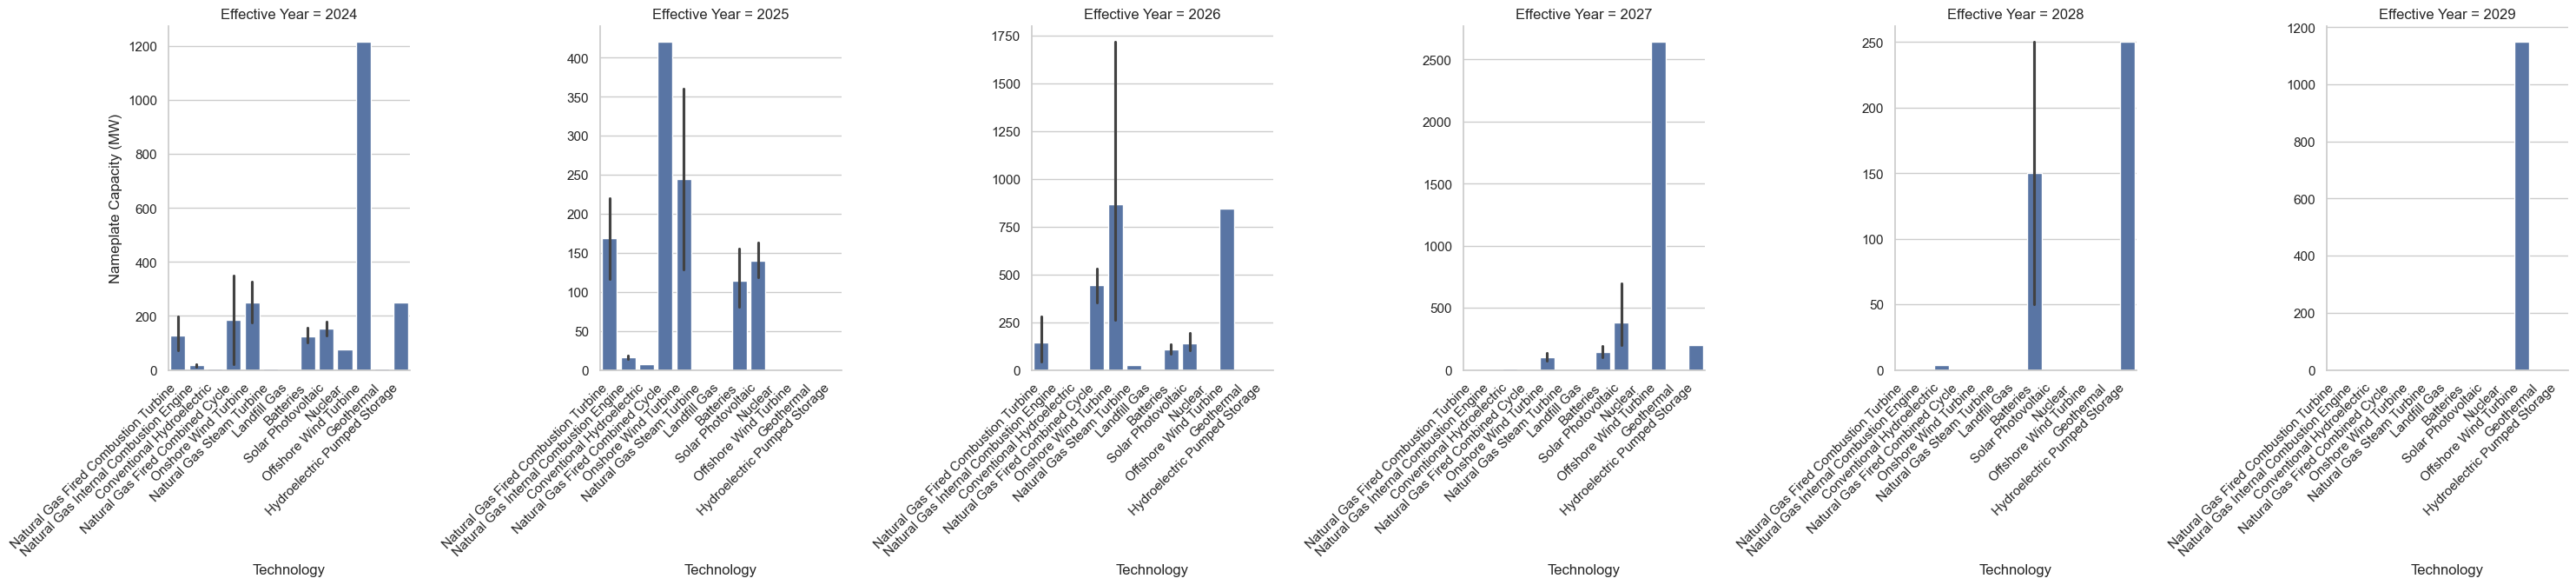

In [69]:
g = sns.catplot(data=future_proposed, x='Technology', y='Nameplate Capacity (MW)', kind='bar', col='Effective Year', sharey=False)

g.set_xticklabels(rotation=45, ha='right')

plt.show()

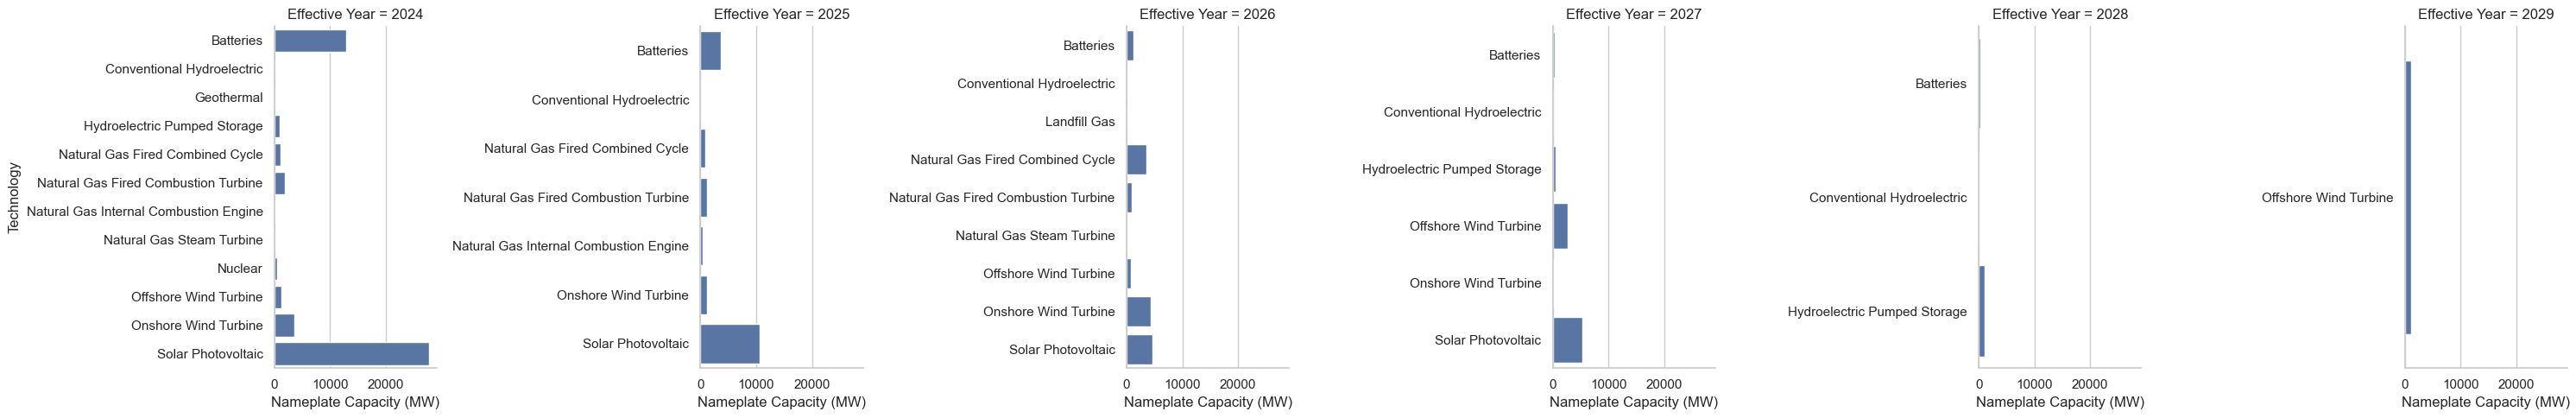

                                Technology  Effective Year  \
0                                Batteries            2024   
1                                Batteries            2025   
2                                Batteries            2026   
3                                Batteries            2027   
4                                Batteries            2028   
15        Natural Gas Fired Combined Cycle            2024   
16        Natural Gas Fired Combined Cycle            2025   
17        Natural Gas Fired Combined Cycle            2026   
18    Natural Gas Fired Combustion Turbine            2024   
19    Natural Gas Fired Combustion Turbine            2025   
20    Natural Gas Fired Combustion Turbine            2026   
21  Natural Gas Internal Combustion Engine            2024   
22  Natural Gas Internal Combustion Engine            2025   
25                                 Nuclear            2024   
26                   Offshore Wind Turbine            2024   
27      

In [73]:
# Calculate total Nameplate Capacity (MW) by Technology and Effective Year
grouped_data = future_proposed.groupby(["Technology", "Effective Year"])["Nameplate Capacity (MW)"].sum().unstack()

# converting back to a df
grouped_data = grouped_data.stack().reset_index()
grouped_data.columns = ['Technology', 'Effective Year', 'Nameplate Capacity (MW)']

grouped_data['Effective Year'] = grouped_data['Effective Year'].astype(int)


grouped_data.to_csv('test_delete_pls.csv', index=False)


g = sns.catplot(data=grouped_data, x='Nameplate Capacity (MW)', y='Technology', kind='bar', col='Effective Year', sharey=False)

plt.show()

# relevant technologies we want to keep
remove_these = ['Conventional Hydroelectric', 'Geothermal', 'Natural Gas Steam Turbine', 
            'Landfill Gas', 'Hydroelectric Pumped Storage']

# we need to get rid of some of the technologies
grouped_data = grouped_data[~grouped_data['Technology'].isin(remove_these)]

print(grouped_data)



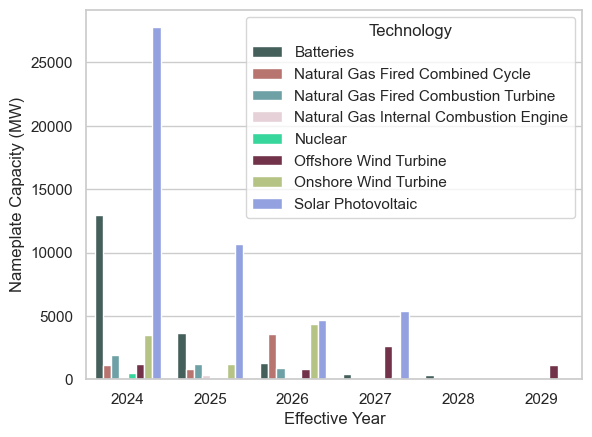

In [81]:
# creating a color palette
le_palette = ["#40655e", "#c46a63", "#64a9af", "#e8ced5", "#1cf1a3", "#7d2748", "#bbcf7a", "#8699ee"]

plt.figure()

sns.barplot(data=grouped_data, x='Effective Year', y='Nameplate Capacity (MW)', hue='Technology',
            palette=le_palette)

plt.show()

goal of this analysis is to create some chloropleth maps with the 
data that we have from the EIA

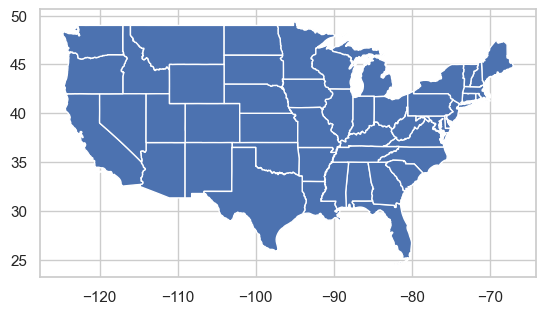

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49 entries, 0 to 50
Data columns (total 94 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   FactFinder GEOID                49 non-null     object  
 1   FIPS                            49 non-null     object  
 2   Name                            49 non-null     object  
 3   State                           49 non-null     object  
 4   Latitude                        49 non-null     float64 
 5   Longitude                       49 non-null     float64 
 6   Square Miles                    49 non-null     float64 
 7   Pop per Square Mile             49 non-null     float64 
 8   Total Households                49 non-null     float64 
 9   Total Households MOE            49 non-null     float64 
 10  Average Household Size          49 non-null     float64 
 11  Average Household Size MOE      49 non-null     float64 
 12  Percent Foreign-Born 

In [89]:
# loading into our env a map of the united states
states = gpd.read_file('input_data/2015-2019-acs-states.geojson')

# taking out non mainland states
states = states[~states['ST'].isin(['AK', 'PR', 'HI'])]

# plotting our map to check it out
states.plot()

# renaming ST to st
states = states.rename(columns={"ST":"State"})

plt.show()

print(states.info())

In [90]:
# grouping data by state
# Calculate total Nameplate Capacity (MW) by Technology and Effective Year
grouped_data_st = future_proposed.groupby(["Technology", "State"])["Nameplate Capacity (MW)"].sum().unstack()

# converting back to a df
grouped_data_st = grouped_data_st.stack().reset_index()
grouped_data_st.columns = ['Technology', 'State', 'Nameplate Capacity (MW)']


print(grouped_data_st)

             Technology State  Nameplate Capacity (MW)
0             Batteries    AZ                    640.0
1             Batteries    CA                   2977.9
2             Batteries    CT                    380.0
3             Batteries    DE                     12.5
4             Batteries    FL                    115.0
..                  ...   ...                      ...
103  Solar Photovoltaic    UT                    882.0
104  Solar Photovoltaic    VA                    968.1
105  Solar Photovoltaic    WA                    260.0
106  Solar Photovoltaic    WI                    200.0
107  Solar Photovoltaic    WV                     50.1

[108 rows x 3 columns]


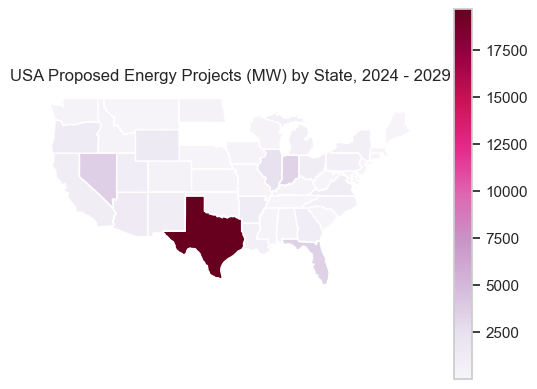

In [107]:
# first we must combine our data 
merged_data = states.merge(grouped_data_st, on='State', how='left')

# plotting data
merged_data.plot(column='Nameplate Capacity (MW)', cmap='PuRd', legend=True)

# visual tweaks
plt.title('USA Proposed Energy Projects (MW) by State, 2024 - 2029')
plt.axis('off')
plt.show()


In [23]:
# aggregating nameplate capacity by state
test_data = merged_data.groupby('State')
print(test_data)